# IMPORTS

In [75]:
import pandas as pd
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, recall_score, precision_score, precision_recall_curve
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from sklearn.model_selection import train_test_split


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rikdifos/credit-card-approval-prediction")

print("Path to dataset files:", path)

Path to dataset files: /home/mazzdi/.cache/kagglehub/datasets/rikdifos/credit-card-approval-prediction/versions/3


# DATA EXPLAIN

### Features

In [3]:
df = pd.read_csv(path + '/application_record.csv', sep=',')

In [4]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [5]:
df.shape

(438557, 18)

**Feature description** - https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/discussion/119320

### Target

#### Для скачивания таргета уже надо перейти на стрраницу Kaggle
https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction/data?select=credit_record.csv

In [6]:
df_target = pd.read_csv('data/credit_record.csv', sep=',')

In [7]:
df_target.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [8]:
df_target.shape

(1048575, 3)

**MONTHS_BALANCE** - The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on  

**STATUS** - 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

### Выводы
1) Всего у нас почти 440к строк с записями о заемщиках.
2) Есть 18 базовых признаков заемщика таких как: зарплата, наличие недвижимости в собственности, налииче машины, возраст и др.
3) Старгетом интереснее, так как он не бинарный. У нас есть несколько групп пользоватлей по сроку просрочки платежа от 1 до 150+ дней. Также есть группа С, которая не просрочила платеж и группа Х, которая не брала займы и не платила по кредиту в этом месяце.

Для нашего упражнения попробуем бинаризовать таргет, так как для нас важно предсказывать дефолтящих клиентов с просрочкой более 90 дней. Получается в класс 1 попадут юзеры с тегами: 3, 4, 5; а в клсс 0 - остальные, кроме класса Х, так как они вообще не брали заем и таких пользователей мы не планируем скорить на проде.

# EDA

In [9]:
df.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [10]:
# Видим константный признак FLAG_MOBIL, который точно не берем в обучение
df['FLAG_MOBIL'].value_counts()

FLAG_MOBIL
1    438557
Name: count, dtype: int64

In [11]:
df = df.drop(columns=['FLAG_MOBIL'])

In [12]:
df.isna().sum()/len(df)

ID                     0.00000
CODE_GENDER            0.00000
FLAG_OWN_CAR           0.00000
FLAG_OWN_REALTY        0.00000
CNT_CHILDREN           0.00000
AMT_INCOME_TOTAL       0.00000
NAME_INCOME_TYPE       0.00000
NAME_EDUCATION_TYPE    0.00000
NAME_FAMILY_STATUS     0.00000
NAME_HOUSING_TYPE      0.00000
DAYS_BIRTH             0.00000
DAYS_EMPLOYED          0.00000
FLAG_WORK_PHONE        0.00000
FLAG_PHONE             0.00000
FLAG_EMAIL             0.00000
OCCUPATION_TYPE        0.30601
CNT_FAM_MEMBERS        0.00000
dtype: float64

In [13]:
# Видим что 30% в OCCUPATION_TYPE имеют пропуски. Учитывая что это категонриальная фича для професии или сферы занятости,
# то заполним пропуски на "Unknown"
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('Unknown')

In [14]:
for col in df.select_dtypes(include=['object']).columns:
    print(df[col].value_counts())
    print('\n')

CODE_GENDER
F    294440
M    144117
Name: count, dtype: int64


FLAG_OWN_CAR
N    275459
Y    163098
Name: count, dtype: int64


FLAG_OWN_REALTY
Y    304074
N    134483
Name: count, dtype: int64


NAME_INCOME_TYPE
Working                 226104
Commercial associate    100757
Pensioner                75493
State servant            36186
Student                     17
Name: count, dtype: int64


NAME_EDUCATION_TYPE
Secondary / secondary special    301821
Higher education                 117522
Incomplete higher                 14851
Lower secondary                    4051
Academic degree                     312
Name: count, dtype: int64


NAME_FAMILY_STATUS
Married                 299828
Single / not married     55271
Civil marriage           36532
Separated                27251
Widow                    19675
Name: count, dtype: int64


NAME_HOUSING_TYPE
House / apartment      393831
With parents            19077
Municipal apartment     14214
Rented apartment         5974
Office apartmen

In [15]:
# Есть явные фичи среди numerical которые можно считать категориальными
df.select_dtypes(exclude=['object']).nunique()

ID                  438510
CNT_CHILDREN            12
AMT_INCOME_TOTAL       866
DAYS_BIRTH           16379
DAYS_EMPLOYED         9406
FLAG_WORK_PHONE          2
FLAG_PHONE               2
FLAG_EMAIL               2
CNT_FAM_MEMBERS         13
dtype: int64

In [16]:
# Есть еще CNT_CHILDREN и CNT_FAM_MEMBERS в которых тоже мало уникальных значений, но в базовом варианте оставим их непрерывными фичами
df['FLAG_WORK_PHONE'] = df['FLAG_WORK_PHONE'].astype('string')
df['FLAG_PHONE'] = df['FLAG_PHONE'].astype('string')
df['FLAG_EMAIL'] = df['FLAG_EMAIL'].astype('string')

In [17]:
# Кажется нелогичным что возраст и стаж работы указан в отрицательных числах
# эти фичи лучше сделать положительными
df['DAYS_BIRTH'] = df['DAYS_BIRTH'].abs()
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].abs()


In [18]:
# При этом можно также явно выделить возрастные группы. Зачастую это помогает модели лучше обучиться.
df['AGE_GROUP'] = pd.cut(df['DAYS_BIRTH'] / 365, bins=[0, 18, 25, 35, 45, 55, 65, 100], labels=['0-18', '18-25', '25-35', '35-45', '45-55', '55-65', '65+'])

In [19]:
# В датасете с заемщиками есть дубликаты, посмотрим на них
df['ID'].nunique()/len(df)

0.9998928303504447

In [20]:
df['ID'].value_counts()[df['ID'].value_counts() > 1].shape

(47,)

In [21]:
double_user_list = df['ID'].value_counts()[df['ID'].value_counts() > 1].index

In [22]:
df[df['ID'].isin(double_user_list)].sort_values(by='DAYS_BIRTH').groupby('ID').first()['NAME_INCOME_TYPE'].value_counts()

NAME_INCOME_TYPE
Working                 25
Commercial associate    20
State servant            2
Name: count, dtype: int64

In [23]:
df[df['ID'].isin(double_user_list)].sort_values(by='DAYS_BIRTH').groupby('ID').agg(
    NAME_INCOME_TYPE_FIRST=('NAME_INCOME_TYPE', 'first'),
    NAME_INCOME_TYPE_LAST=('NAME_INCOME_TYPE', 'last'),
)

,NAME_INCOME_TYPE_FIRST,NAME_INCOME_TYPE_LAST
ID,,
7022197,Working,Commercial associate
7022327,Commercial associate,Commercial associate
7023108,Working,Working
7023651,Commercial associate,Commercial associate
7024111,Commercial associate,Working
7036518,Working,Working
7045794,Working,Working
7045885,Commercial associate,Pensioner
7046068,Working,Pensioner


In [24]:
df[df['ID'] == 7282535]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
428166,7282535,F,N,N,1,202500.0,Commercial associate,Secondary / secondary special,Civil marriage,Municipal apartment,16819,521,0,0,0,Laborers,3.0,45-55
433158,7282535,F,N,Y,0,63000.0,Pensioner,Secondary / secondary special,Married,House / apartment,21124,365243,0,1,0,Unknown,2.0,55-65


In [25]:
df[df['ID'] == 7207977]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
427114,7207977,F,N,Y,0,315000.0,Pensioner,Higher education,Married,House / apartment,23688,365243,0,0,0,Unknown,2.0,55-65
427883,7207977,F,N,N,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,16860,1002,0,0,0,High skill tech staff,1.0,45-55


In [26]:
# Судя по всему это люди, которые со временем вышли на пенсию или стал commercial associate
# Но есть и те, кто был в статусе Working и в нем остался
# В этом случае меняется семейное положение
df[df['ID'] == 7742298]

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
424819,7742298,F,N,Y,0,144000.0,Working,Secondary / secondary special,Widow,House / apartment,20626,1455,0,0,0,Cooking staff,1.0,55-65
430436,7742298,M,N,N,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,18239,5428,1,0,0,Unknown,2.0,45-55


In [27]:
# Судя пор всему у нас есть запись на некоторых заемщиков в разное время и нвдо понять, какую из них надо взять для нашего таргета.
# Для baseline решения подойдет последняя запись, так как она самая свежая.
df = df.sort_values(by='DAYS_BIRTH').drop_duplicates(subset=['ID'], keep='last')

In [28]:
# Добавляем таргет для обучения
df_target['TARGET'] = df_target['STATUS'].apply(lambda x: 1 if x in ['3', '4', '5'] else 0)

In [29]:
# Видим сильный дисбаланс классов
# Значит будем пробовать сбалансировать классы при обучении, на уровне оверсемлинга и андерсемплинга
# Также попробуем поработать с фильтром выбросов. Вероятно это поможет сделать баланс классов более подходящим для обучения модели
# Также с осторожностью смотрим Accuracy и ROC-AUC, так как они в таких случаях не отражают истинное качество модели
# Вместо них лучше использовать F1-score и PR-AUC
df_target['TARGET'].value_counts(normalize=True)

TARGET
0    0.997868
1    0.002132
Name: proportion, dtype: float64

In [30]:
df.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
238,5009058,F,Y,Y,0,112500.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,7489,797,0,1,1,Private service staff,1.0,18-25
391723,6661174,F,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,7678,209,0,0,1,Core staff,1.0,18-25
391724,6661175,F,N,Y,0,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,7678,209,0,0,1,Core staff,1.0,18-25
246589,6037220,M,Y,Y,0,80397.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,7680,262,1,1,0,Sales staff,1.0,18-25
246588,6037219,M,Y,Y,0,80397.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,7680,262,1,1,0,Sales staff,1.0,18-25


In [31]:
df_target.head()

,ID,MONTHS_BALANCE,STATUS,TARGET
0,5001711,0,X,0
1,5001711,-1,0,0
2,5001711,-2,0,0
3,5001711,-3,0,0
4,5001712,0,C,0


In [32]:
# Total dataframe. Убираем STATUS так как на его основе мы делали таргет
df_total = pd.merge(df_target.drop('STATUS', axis=1), df, on='ID', how='inner')

In [33]:
df_total.isna().sum()/len(df_total)

ID                     0.0
MONTHS_BALANCE         0.0
TARGET                 0.0
CODE_GENDER            0.0
FLAG_OWN_CAR           0.0
FLAG_OWN_REALTY        0.0
CNT_CHILDREN           0.0
AMT_INCOME_TOTAL       0.0
NAME_INCOME_TYPE       0.0
NAME_EDUCATION_TYPE    0.0
NAME_FAMILY_STATUS     0.0
NAME_HOUSING_TYPE      0.0
DAYS_BIRTH             0.0
DAYS_EMPLOYED          0.0
FLAG_WORK_PHONE        0.0
FLAG_PHONE             0.0
FLAG_EMAIL             0.0
OCCUPATION_TYPE        0.0
CNT_FAM_MEMBERS        0.0
AGE_GROUP              0.0
dtype: float64

In [34]:
df_total.head()

,ID,MONTHS_BALANCE,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
0,5008804,0,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
1,5008804,-1,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
2,5008804,-2,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
3,5008804,-3,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
4,5008804,-4,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35


# DISTRIBUTION ANALYSIS

In [35]:
df_total.head()

,ID,MONTHS_BALANCE,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
0,5008804,0,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
1,5008804,-1,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
2,5008804,-2,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
3,5008804,-3,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35
4,5008804,-4,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,12005,4542,1,0,0,Unknown,2.0,25-35


In [36]:
df_total['TARGET'].value_counts(normalize=True).mul(100).round(2)

TARGET
0    99.74
1     0.26
Name: proportion, dtype: float64

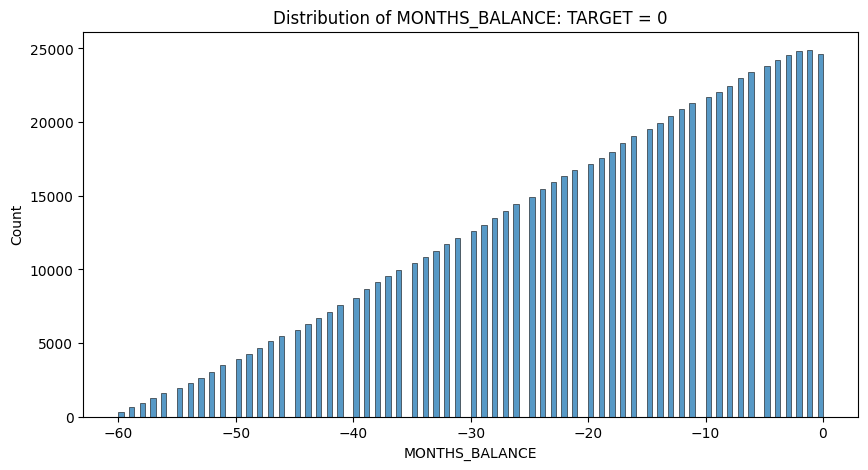

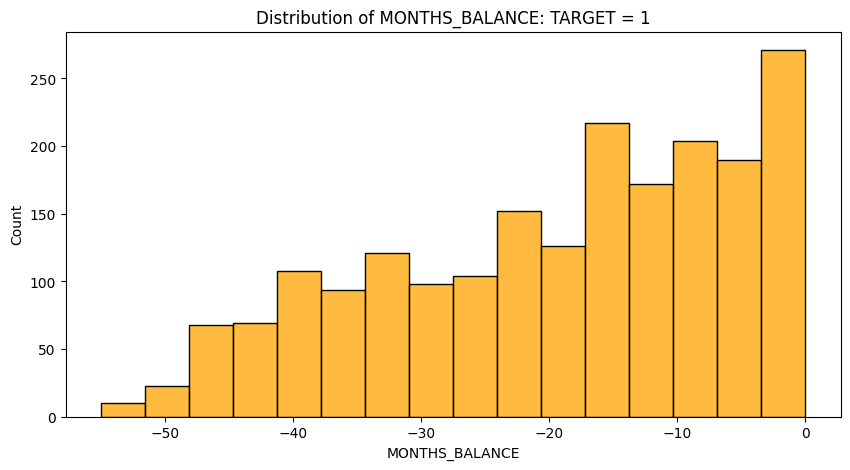

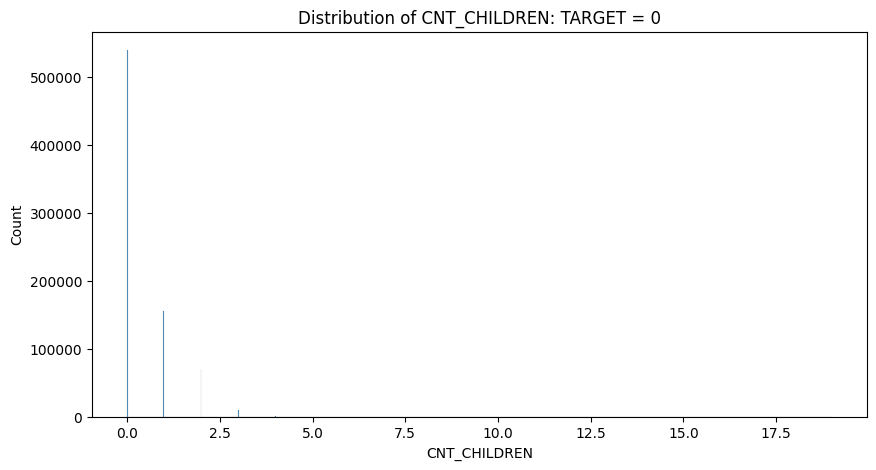

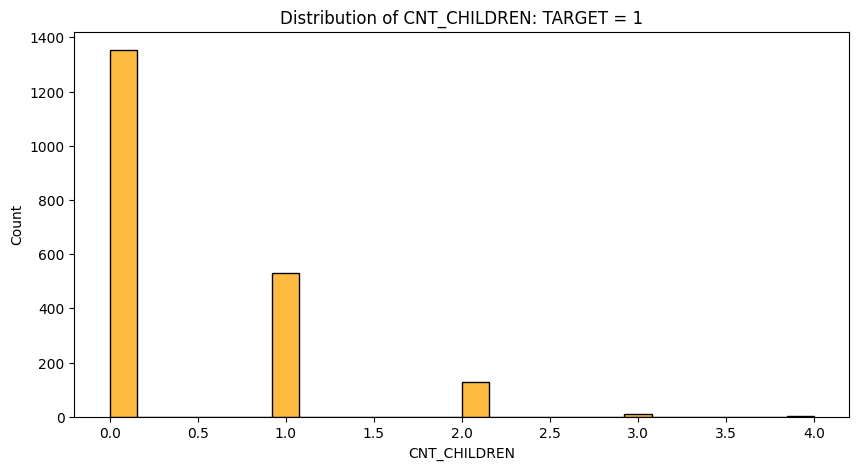

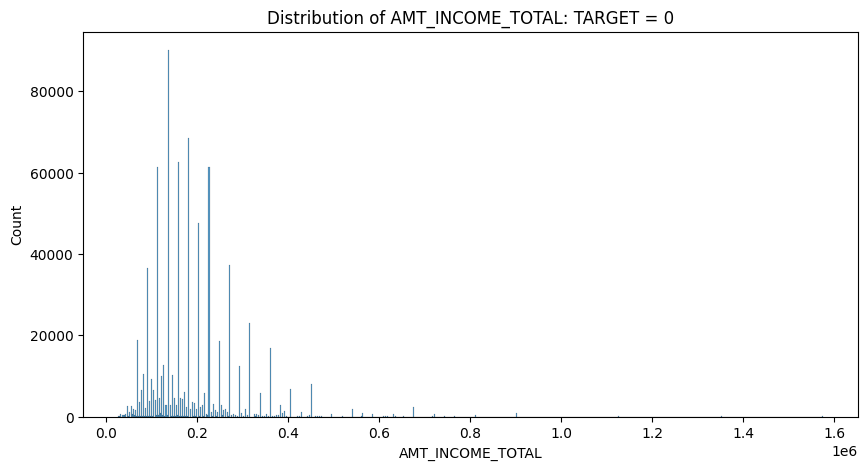

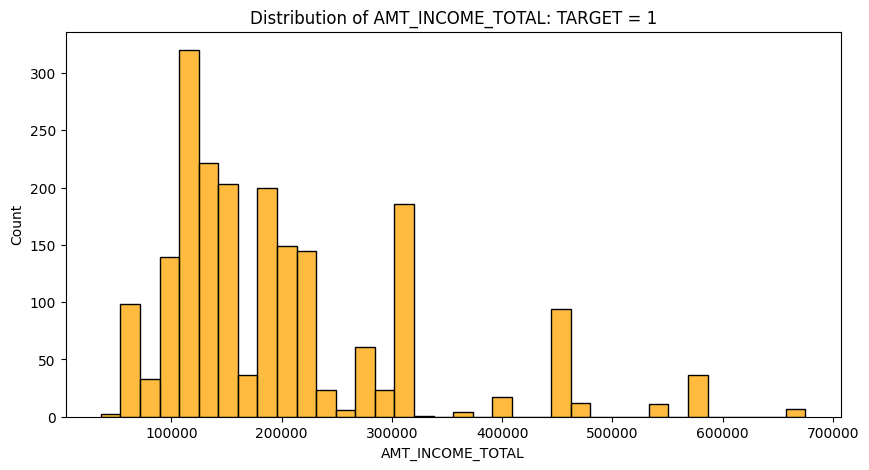

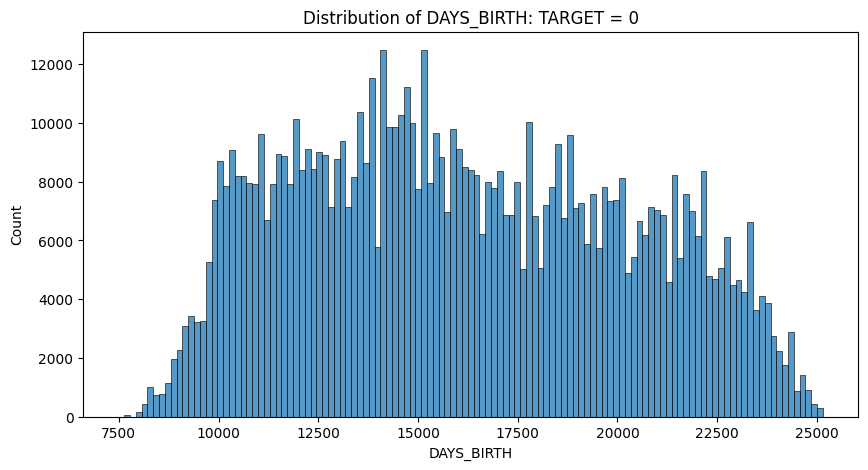

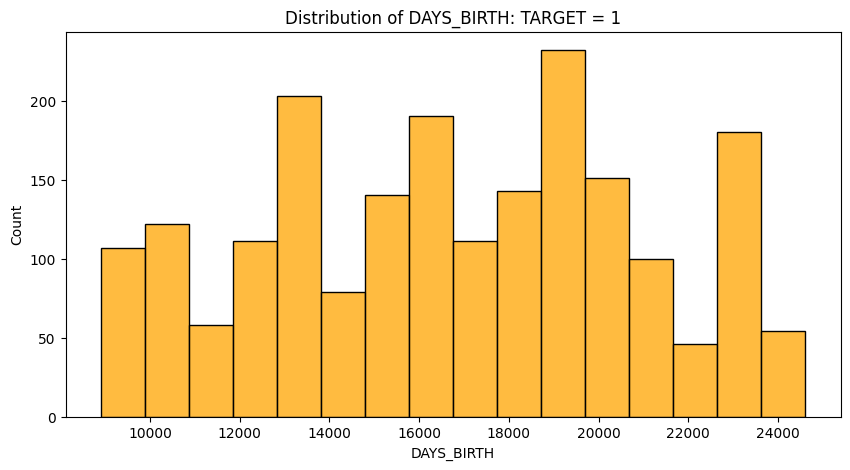

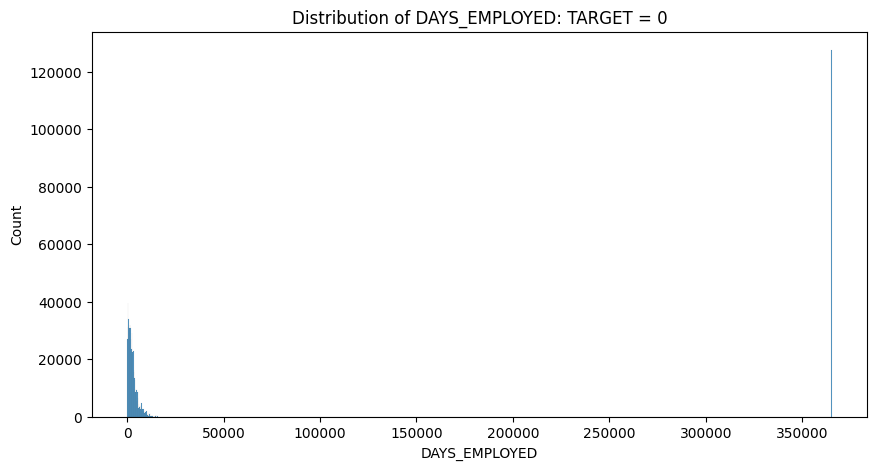

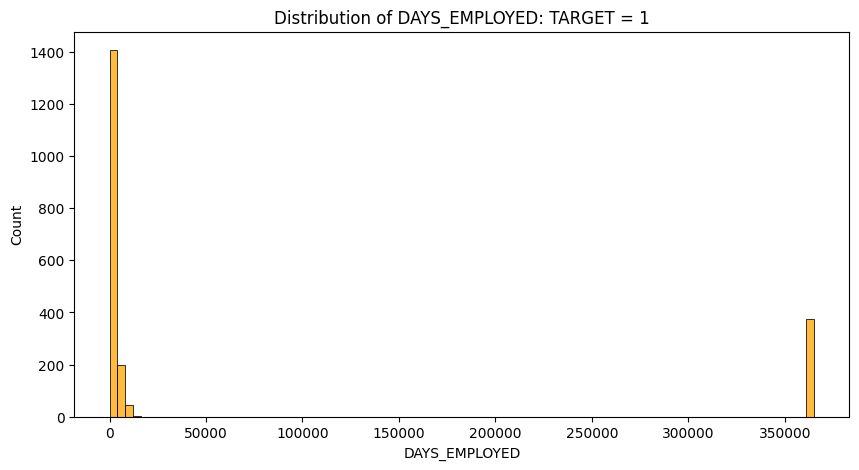

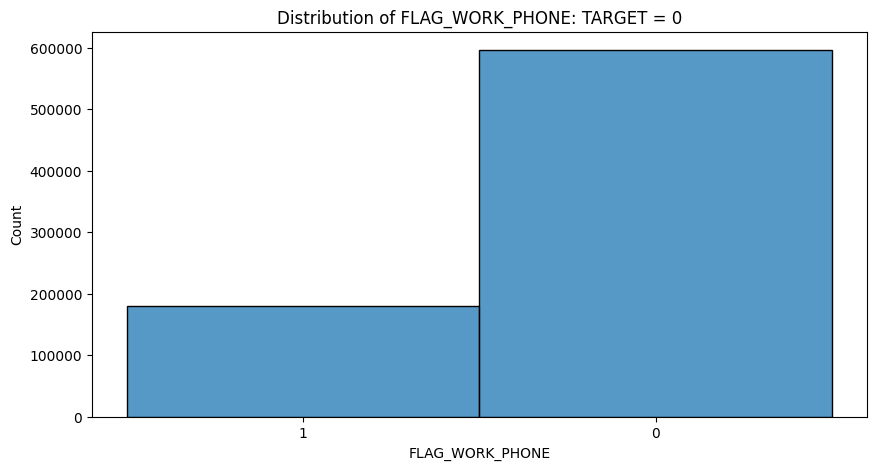

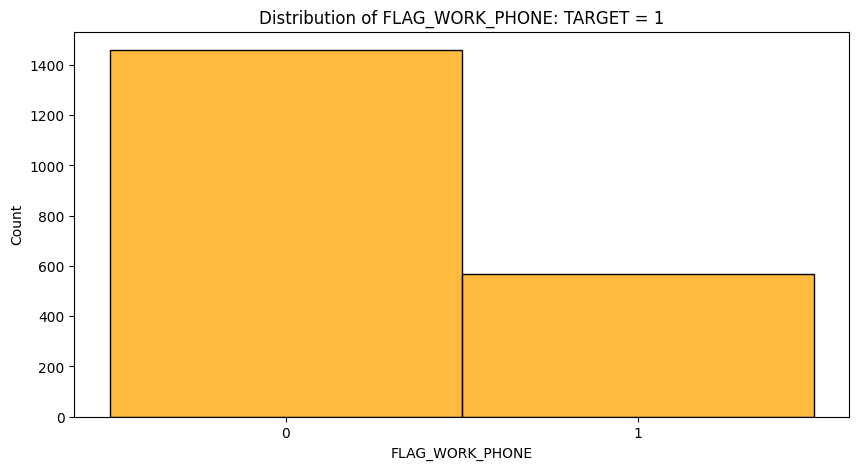

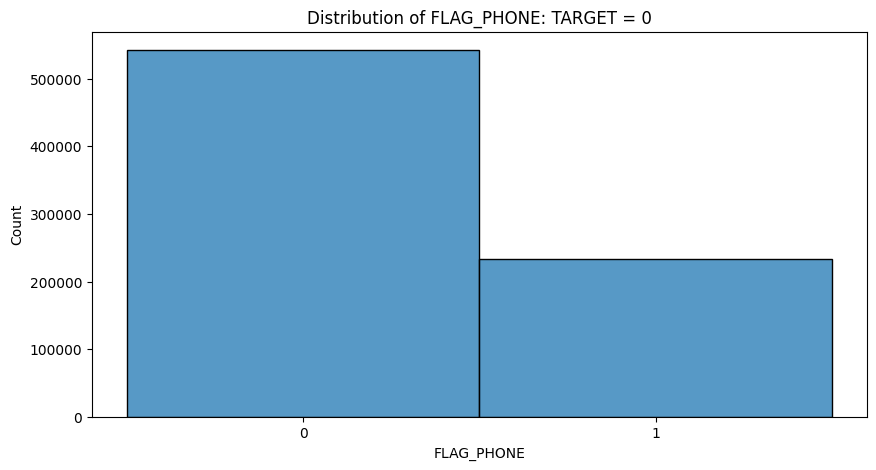

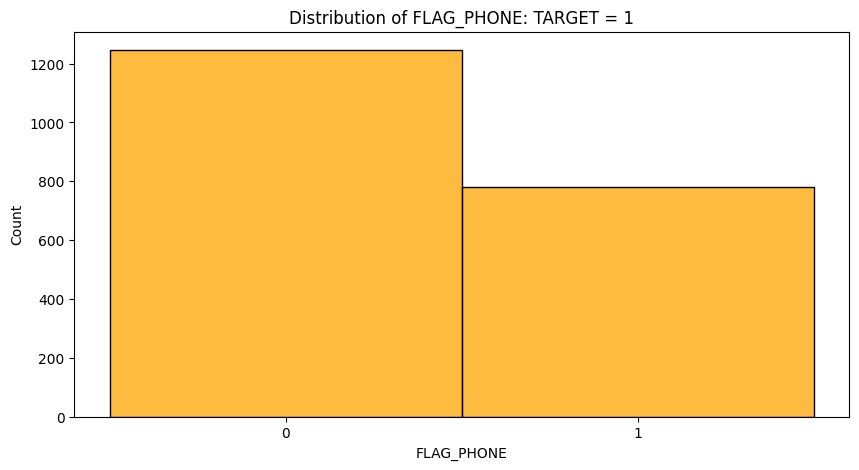

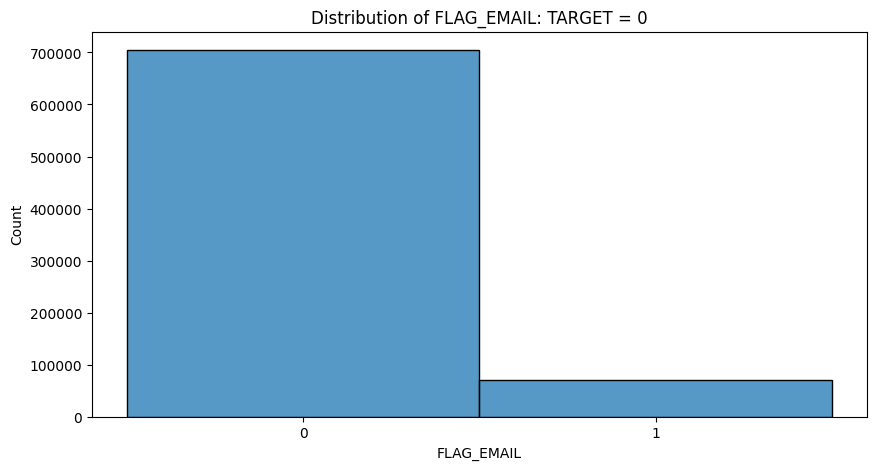

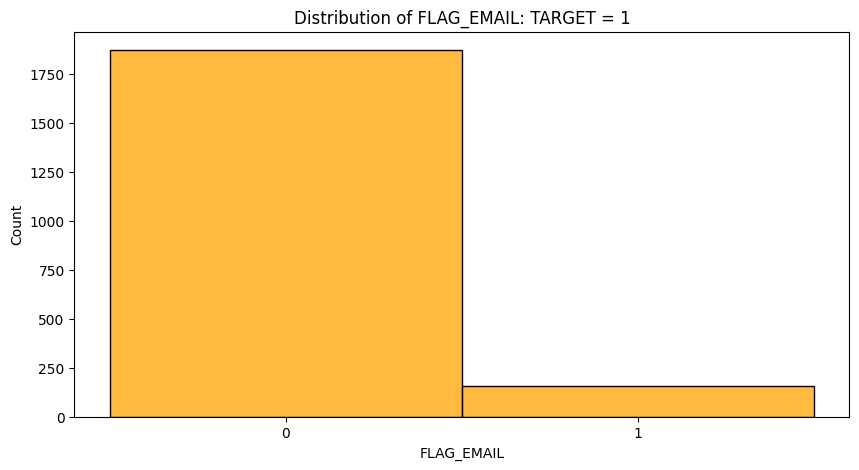

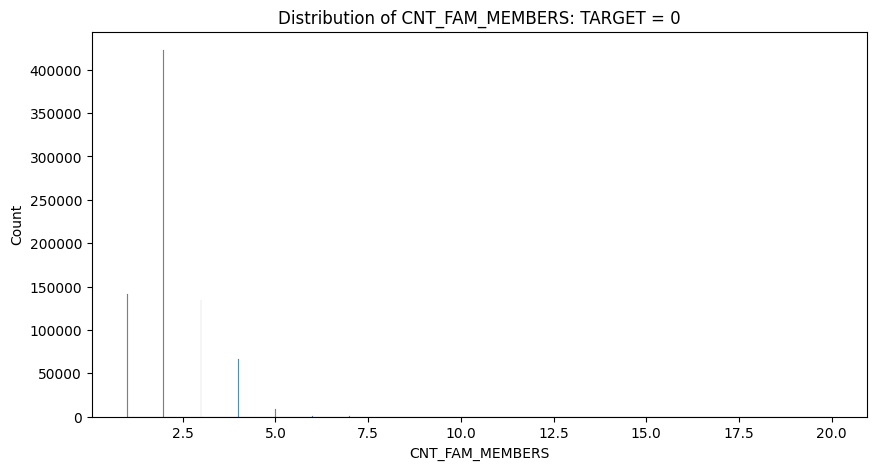

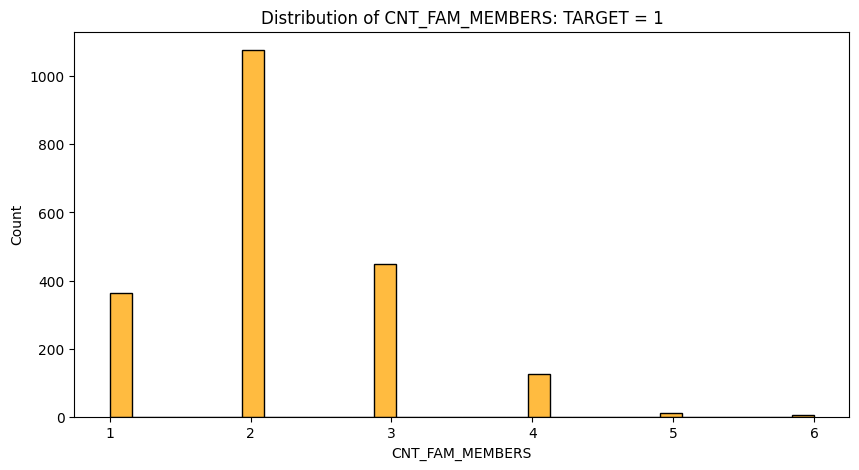

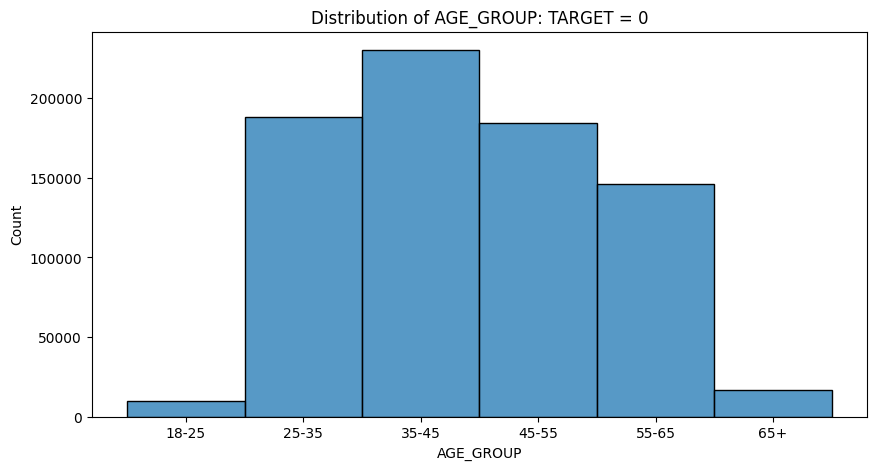

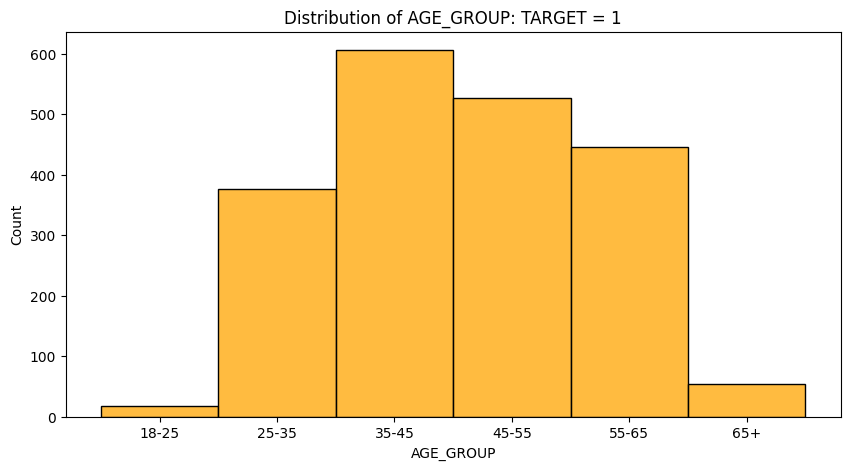

In [37]:
for col in df_total.select_dtypes(exclude=['object']).columns:
    if col in ['TARGET', 'ID']:
        continue
    plt.figure(figsize=(10, 5))
    sns.histplot(df_total[df_total['TARGET'] == 0], x=col)
    plt.title(f'Distribution of {col}: TARGET = 0')
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.histplot(df_total[df_total['TARGET'] == 1], x=col, color='orange')
    plt.title(f'Distribution of {col}: TARGET = 1')
    plt.show()


In [38]:
# Видим странные аномалии в фиче DAYS_EMPLOYED. Посмотрим на них подробнее
df_total[df_total['DAYS_EMPLOYED'] > 30000]

,ID,MONTHS_BALANCE,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE_GROUP
137,5008812,-4,0,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,22464,365243,0,0,0,Unknown,1.0,55-65
138,5008812,-5,0,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,22464,365243,0,0,0,Unknown,1.0,55-65
139,5008812,-6,0,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,22464,365243,0,0,0,Unknown,1.0,55-65
140,5008812,-7,0,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,22464,365243,0,0,0,Unknown,1.0,55-65
141,5008812,-8,0,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,22464,365243,0,0,0,Unknown,1.0,55-65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777243,5150423,-8,0,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,22116,365243,0,0,0,Unknown,1.0,55-65
777244,5150423,-9,0,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,22116,365243,0,0,0,Unknown,1.0,55-65
777245,5150423,-10,0,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,22116,365243,0,0,0,Unknown,1.0,55-65
777246,5150423,-11,0,F,N,Y,0,67500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,22116,365243,0,0,0,Unknown,1.0,55-65


In [39]:
for col in df.select_dtypes(include=['object']).columns:
    print(df_total[df_total['DAYS_EMPLOYED'] > 30000][col].value_counts())
    print('\n')

CODE_GENDER
F    109148
M     18824
Name: count, dtype: int64


FLAG_OWN_CAR
N    100248
Y     27724
Name: count, dtype: int64


FLAG_OWN_REALTY
Y    97021
N    30951
Name: count, dtype: int64


NAME_INCOME_TYPE
Pensioner    127972
Name: count, dtype: int64


NAME_EDUCATION_TYPE
Secondary / secondary special    101200
Higher education                  22075
Lower secondary                    3468
Incomplete higher                  1211
Academic degree                      18
Name: count, dtype: int64


NAME_FAMILY_STATUS
Married                 82073
Widow                   16469
Single / not married    14519
Separated                7536
Civil marriage           7375
Name: count, dtype: int64


NAME_HOUSING_TYPE
House / apartment      123037
Municipal apartment      3509
Office apartment          638
Rented apartment          635
With parents              103
Co-op apartment            50
Name: count, dtype: int64


OCCUPATION_TYPE
Unknown    127972
Name: count, dtype: int64




In [40]:
# Это все пенсионеры, видимо в системе что то сломалость и им все еще капает стаж работы

In [41]:
df_total.shape

(777715, 20)

In [42]:
len(df_total[df_total['DAYS_EMPLOYED'] > 300000])/len(df_total)
# 10% пенсионеров
# Попробуем удалить их из датасета

0.16454871000302168

In [43]:
len(df_total[df_total['DAYS_EMPLOYED'] > 300000])/len(df_total[df_total['NAME_INCOME_TYPE'] == 'Pensioner'])


0.9967287681475482

In [44]:
# Таких звписей всего 16%, но при этом это почти все пенсионеры, потому удалять их не будем
# Для bseline можем разбить DAYS_EMPLOYED на бины как мы сделали с возрастом
df_total['DAYS_EMPLOYED_BIN'] = pd.cut(df_total['DAYS_EMPLOYED'], bins=[1, 365, 3*365, 5*365, 10*365, 40*365, df_total['DAYS_EMPLOYED'].max()], labels=['<1 year', '1-3 year', '3-5 year', '5-10 year', '10-40 year', '40+ year'])

In [45]:
df_total['DAYS_EMPLOYED_BIN'].value_counts()

DAYS_EMPLOYED_BIN
5-10 year     201440
10-40 year    164280
40+ year      129240
1-3 year      117285
3-5 year      114369
<1 year        51101
Name: count, dtype: int64

In [46]:
df_total.shape

(777715, 21)

In [47]:
df_total.isna().sum()/len(df_total)

ID                     0.0
MONTHS_BALANCE         0.0
TARGET                 0.0
CODE_GENDER            0.0
FLAG_OWN_CAR           0.0
FLAG_OWN_REALTY        0.0
CNT_CHILDREN           0.0
AMT_INCOME_TOTAL       0.0
NAME_INCOME_TYPE       0.0
NAME_EDUCATION_TYPE    0.0
NAME_FAMILY_STATUS     0.0
NAME_HOUSING_TYPE      0.0
DAYS_BIRTH             0.0
DAYS_EMPLOYED          0.0
FLAG_WORK_PHONE        0.0
FLAG_PHONE             0.0
FLAG_EMAIL             0.0
OCCUPATION_TYPE        0.0
CNT_FAM_MEMBERS        0.0
AGE_GROUP              0.0
DAYS_EMPLOYED_BIN      0.0
dtype: float64

In [48]:
numeric_features = df_total.drop(columns=['TARGET', 'ID']).select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df_total.select_dtypes(include=['object', 'string', 'category']).columns.tolist()

# BASELINE MODEL LOGREG

In [105]:
# Максимум 19 ктегорий в категориальных фичах. Можем использовать OHE.

In [49]:
df_total_lr = pd.concat([df_total.drop(categorical_features, axis=1), pd.get_dummies(df_total[categorical_features], drop_first=True).astype('int8')], axis=1)

In [50]:
df_total_lr.shape

(777715, 60)

In [75]:
df_total_lr.isna().sum()/len(df_total_lr)

ID                                                   0.0
MONTHS_BALANCE                                       0.0
TARGET                                               0.0
CNT_CHILDREN                                         0.0
AMT_INCOME_TOTAL                                     0.0
DAYS_BIRTH                                           0.0
DAYS_EMPLOYED                                        0.0
CNT_FAM_MEMBERS                                      0.0
CODE_GENDER_M                                        0.0
FLAG_OWN_CAR_Y                                       0.0
FLAG_OWN_REALTY_Y                                    0.0
NAME_INCOME_TYPE_Pensioner                           0.0
NAME_INCOME_TYPE_State servant                       0.0
NAME_INCOME_TYPE_Student                             0.0
NAME_INCOME_TYPE_Working                             0.0
NAME_EDUCATION_TYPE_Higher education                 0.0
NAME_EDUCATION_TYPE_Incomplete higher                0.0
NAME_EDUCATION_TYPE_Lower secon

In [111]:
from sklearn.linear_model import LogisticRegression

In [112]:
from sklearn.model_selection import train_test_split

In [113]:
X = df_total_lr.drop(['TARGET', 'ID'], axis=1)
y = df_total_lr['TARGET']
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [114]:
base_linear_model = LogisticRegression(max_iter=1000, class_weight='balanced')
base_linear_model.fit(X_train, y_train)

/home/mazzdi/Документы/GIT/Learning/kc_ml_engeneering/Final Project/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [115]:
base_linear_model.score(X_test, y_test)

0.6589046115865066

In [120]:
roc_auc_score(y_test, base_linear_model.predict_proba(X_test)[:, 1])

0.7221381932222006

In [117]:
average_precision_score(y_test, base_linear_model.predict_proba(X_test)[:, 1])

0.009724127409438116

In [118]:
f1_score(y_test, base_linear_model.predict(X_test))

0.009188189814555438

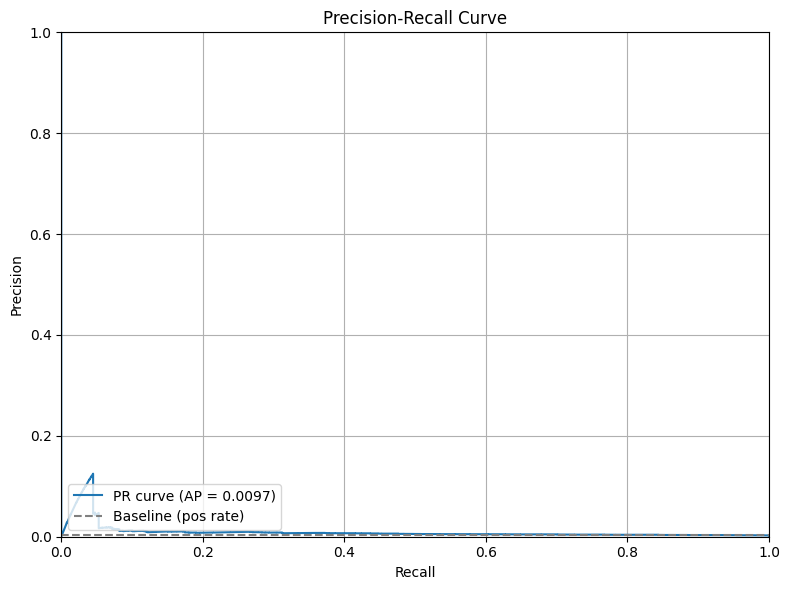

In [124]:
# Precision-Recall curve visualization
model_for_pr = base_linear_model if 'best_model' in globals() else model
probas = model_for_pr.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: Логистическая регрессия показала себя очень плохо, ROC-AUC ниже 0.8, а PR-AUC где то на дне. PR кривая также выглядит очень плохо. Модель не жизнеспособна.

# BASELINE MODEL CATBOOST

In [56]:
from sklearn.model_selection import train_test_split

In [129]:
X = df_total.drop(['TARGET', 'ID'], axis=1)
y = df_total['TARGET']
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [128]:
from catboost import CatBoostClassifier

In [129]:
base_catboost_model = CatBoostClassifier(custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'], task_type='GPU', cat_features=categorical_features + ['AGE_GROUP'])
base_catboost_model.fit(X_train, y_train, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions

In [130]:
roc_auc_score(y_test, base_catboost_model.predict_proba(X_test)[:, 1])

0.9297950875642365

In [131]:
average_precision_score(y_test, base_catboost_model.predict_proba(X_test)[:, 1])

0.4103213951418655

In [132]:
f1_score(y_test, base_catboost_model.predict(X_test))

0.29385964912280704

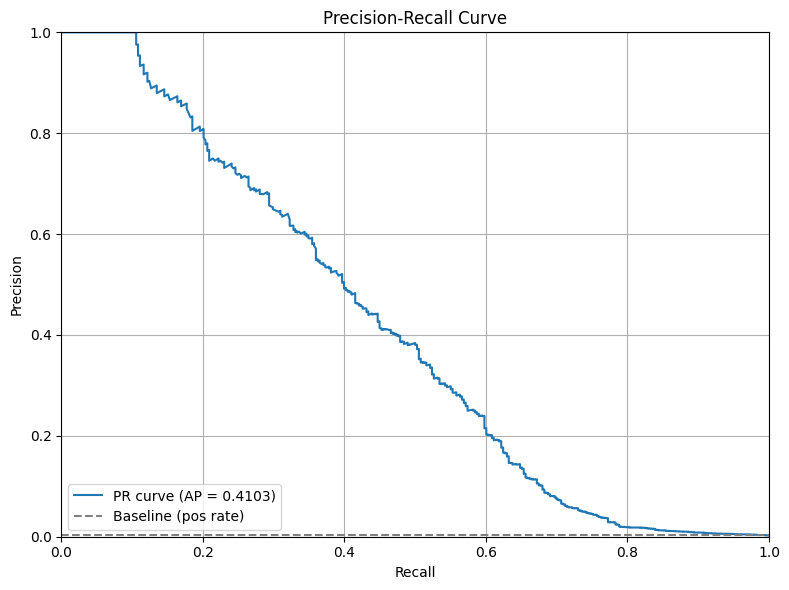

In [133]:
# Precision-Recall curve visualization
probas = base_catboost_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: Катбуст улавливает больше нелинейных взаимосвязей и показывает намного лоучше резултаты, чем логистическая регрессия по целевым метриками. ROC-AUC выше 0.9, при этом PR-AUC хоть и вырос, все еще достаточно плох и равен 0.41. Бизнесово для нас важнее снижать количество FN случаев, чтобы снизить вероятность выдачи кредита потенциально дефолтящему клиенту, поэтому мы уже можем подобрать оптимальный трешхолд для нужного балланса Precision/Recall. Наша цель - получить максимально высокий Recall при оптимальном трейдофе с Precision.

# BASELINE MODEL CATBOOST + CLASS BALANCE

In [39]:
X = df_total.drop(['TARGET', 'ID'], axis=1)
y = df_total['TARGET']
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [40]:
from catboost import CatBoostClassifier

In [ ]:
balanced_catboost_model = CatBoostClassifier(
    custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'], 
    task_type='GPU', cat_features=categorical_features + ['AGE_GROUP'],
    auto_class_weights='Balanced'
    )
balanced_catboost_model.fit(X_train, y_train, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [46]:
roc_auc_score(y_test, balanced_catboost_model.predict_proba(X_test)[:, 1])

0.9766218227839727

In [47]:
average_precision_score(y_test, balanced_catboost_model.predict_proba(X_test)[:, 1])

0.3702907202494028

In [48]:
f1_score(y_test, balanced_catboost_model.predict(X_test))

0.19455894476504534

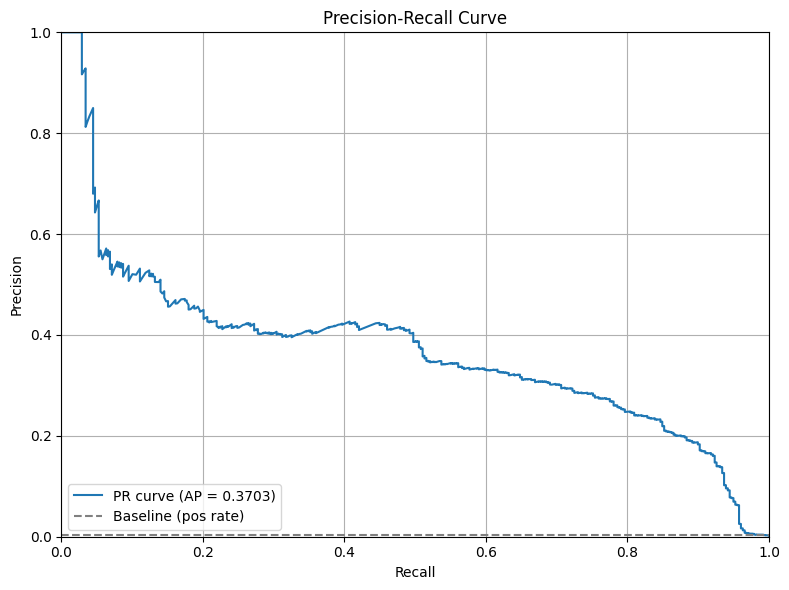

In [50]:
# Precision-Recall curve visualization
probas = balanced_catboost_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

In [49]:
sqrt_balanced_catboost_model = CatBoostClassifier(
    custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'], 
    task_type='GPU', cat_features=categorical_features + ['AGE_GROUP'],
    auto_class_weights='SqrtBalanced'
    )
sqrt_balanced_catboost_model.fit(X_train, y_train, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [51]:
roc_auc_score(y_test, sqrt_balanced_catboost_model.predict_proba(X_test)[:, 1])

0.9703505587242255

In [52]:
average_precision_score(y_test, sqrt_balanced_catboost_model.predict_proba(X_test)[:, 1])

0.4427705985820185

In [53]:
f1_score(y_test, sqrt_balanced_catboost_model.predict(X_test))

0.4099279423538831

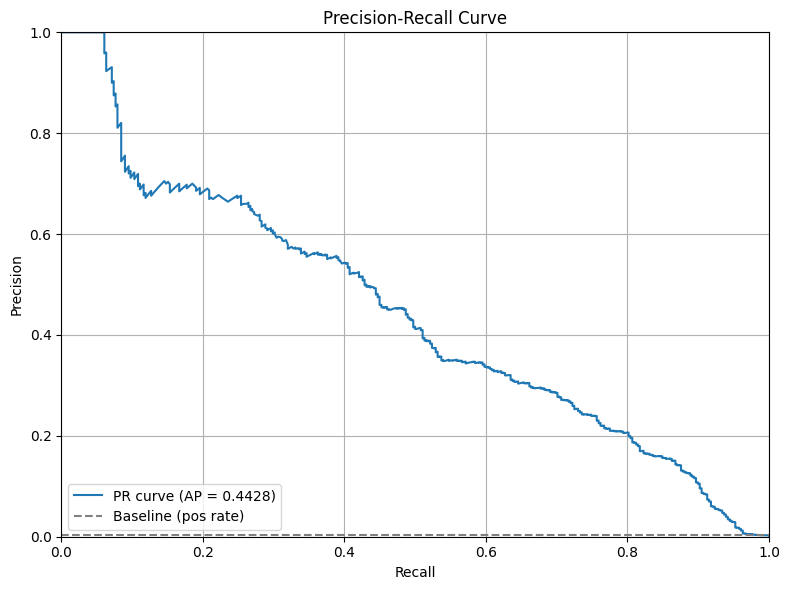

In [54]:
# Precision-Recall curve visualization
probas = sqrt_balanced_catboost_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: Балансировка классов Balanced хоть и ухудшила AP но дало кривую лучше для подбора порога для максисизации Recall. А вот SqrtBqlqnced стартегия дала рост по всем ключевым метрикам (F1, RoC-AUC, PR-AUC). Пока что оставляем ее для дальнеших тестов.

# BASELINE CATBOOST + SMOTE

In [50]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [51]:
df_total_lr.head()

,ID,MONTHS_BALANCE,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,CODE_GENDER_M,FLAG_OWN_CAR_Y,...,AGE_GROUP_25-35,AGE_GROUP_35-45,AGE_GROUP_45-55,AGE_GROUP_55-65,AGE_GROUP_65+,DAYS_EMPLOYED_BIN_1-3 year,DAYS_EMPLOYED_BIN_3-5 year,DAYS_EMPLOYED_BIN_5-10 year,DAYS_EMPLOYED_BIN_10-40 year,DAYS_EMPLOYED_BIN_40+ year
0,5008804,0,0,0,427500.0,12005,4542,2.0,1,1,...,1,0,0,0,0,0,0,0,1,0
1,5008804,-1,0,0,427500.0,12005,4542,2.0,1,1,...,1,0,0,0,0,0,0,0,1,0
2,5008804,-2,0,0,427500.0,12005,4542,2.0,1,1,...,1,0,0,0,0,0,0,0,1,0
3,5008804,-3,0,0,427500.0,12005,4542,2.0,1,1,...,1,0,0,0,0,0,0,0,1,0
4,5008804,-4,0,0,427500.0,12005,4542,2.0,1,1,...,1,0,0,0,0,0,0,0,1,0


In [52]:
scaler = StandardScaler()

In [53]:
d2_data = TruncatedSVD(n_components=2, random_state=42).fit_transform(scaler.fit_transform(df_total_lr.drop(columns=['TARGET', 'ID'])))

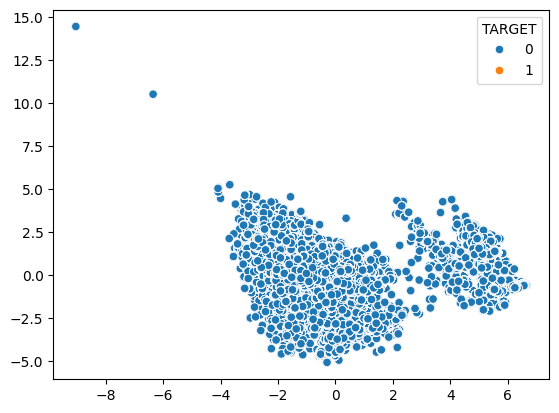

In [55]:
sns.scatterplot(x=d2_data[:, 0], y=d2_data[:, 1], hue=df_total_lr['TARGET'])
plt.show()
# BASELINE + OPTUNA

In [61]:
oversampler = SMOTE(random_state=42, k_neighbors=10)
undersampler = TomekLinks(n_jobs=-1)

In [85]:
X = df_total_lr.drop(['TARGET', 'ID'], axis=1)
y = df_total_lr['TARGET']
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [86]:
X_train_os, y_train_os = oversampler.fit_resample(X_train, y_train)

In [97]:
smote_catboost_model = CatBoostClassifier(
    custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'], 
    task_type='GPU',
    auto_class_weights='SqrtBalanced'
    )
smote_catboost_model.fit(X_train_os, y_train_os, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [98]:
roc_auc_score(y_test, smote_catboost_model.predict_proba(X_test)[:, 1])

0.9644206363698518

In [99]:
average_precision_score(y_test, smote_catboost_model.predict_proba(X_test)[:, 1])

0.39687349055945786

In [100]:
f1_score(y_test, smote_catboost_model.predict(X_test))

0.2570003835826621

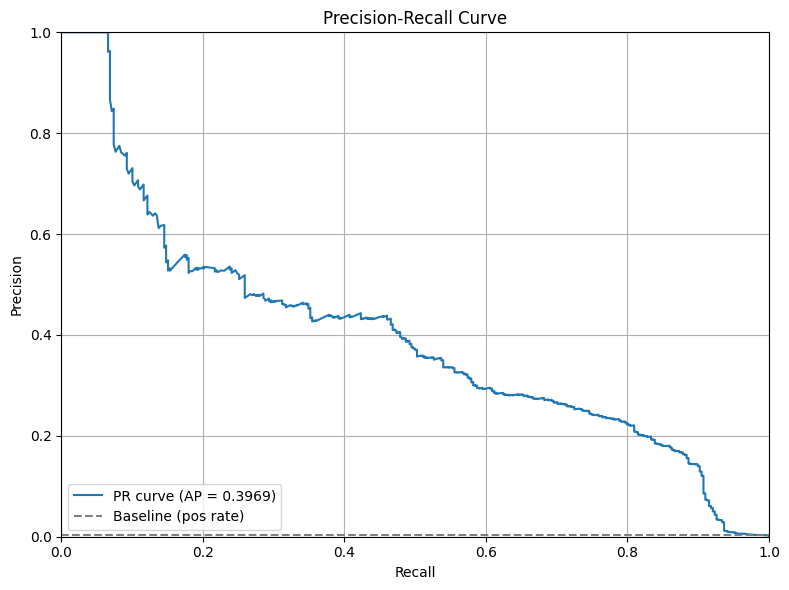

In [101]:
# Precision-Recall curve visualization
probas = smote_catboost_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

In [102]:
X = df_total_lr.drop(['TARGET', 'ID'], axis=1)
y = df_total_lr['TARGET']
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [103]:
X_train_us, y_train_us = undersampler.fit_resample(X_train, y_train)

In [104]:
smote_catboost_model = CatBoostClassifier(
    custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'], 
    task_type='GPU',
    auto_class_weights='SqrtBalanced'
    )
smote_catboost_model.fit(X_train_us, y_train_us, plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


In [105]:
roc_auc_score(y_test, smote_catboost_model.predict_proba(X_test)[:, 1])

0.9712504285845567

In [106]:
average_precision_score(y_test, smote_catboost_model.predict_proba(X_test)[:, 1])

0.44324152468999223

In [107]:
f1_score(y_test, smote_catboost_model.predict(X_test))

0.4091990483743061

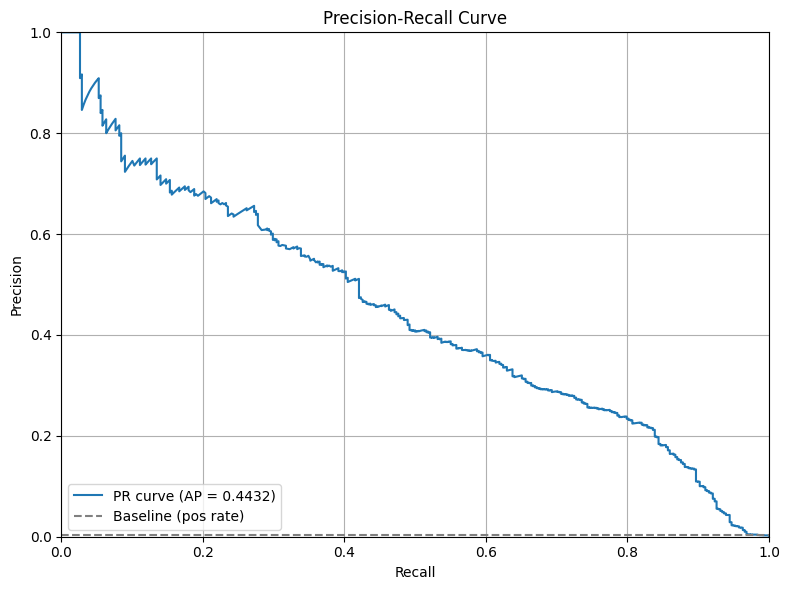

In [108]:
# Precision-Recall curve visualization
probas = smote_catboost_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: SMOTE дал прирост в ключевых метриках хуже. чем балансировка классов (SMOTE + балансировка ожидаемо не дает доп эффекта). А вот undersampling с TomekLinks улучшил качество моднли почти также как балансировка классов. Для дальнейшего перебора гиперпараметров попробуем версию с балансировкой классов и с использованием TomekLinks. Так как это принципиально разные подходы к предобработке данных, возможно это даст различные результаты.

# BASELINE + OPTUNA

In [130]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 2500, 10000, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 5.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 5.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 32),
    }

    model = CatBoostClassifier(
        **params,
        task_type='GPU',
        eval_metric='PRAUC',
        custom_metric=['AUC', 'F1', 'Recall', 'Precision', 'PRAUC'],
        random_seed=42,
    )

    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        cat_features=categorical_features,
        use_best_model=True,
        early_stopping_rounds=100,
        verbose=False,
        plot=False,
    )

    preds = model.predict_proba(X_test)[:, 1]
    pr_auc = average_precision_score(y_test, preds)
    trial.set_user_attr('best_iteration', model.get_best_iteration())
    trial.set_user_attr('model', model)
    return pr_auc


study = optuna.create_study(direction='maximize', study_name='catboost_pr_auc')
study.optimize(objective, n_trials=20, timeout=3600, show_progress_bar=True)

print(f'Best PR-AUC: {study.best_value:.5f}')
print('Best parameters:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')

  0%|          | 0/20 [00:00<?, ?it/s]

Default metric period is 5 because AUC, PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of the positive class predictions is 0. Setting Precision metric value to the default 0
Number of th

Best PR-AUC: 0.56785
Best parameters:
  iterations: 9775
  depth: 9
  learning_rate: 0.023879178170464786
  l2_leaf_reg: 1.5320148839110725
  bagging_temperature: 0.06639798620648962
  random_strength: 3.2983294811717814
  border_count: 141
  grow_policy: SymmetricTree
  min_data_in_leaf: 31


In [131]:
best_model = study.best_trial.user_attrs['model']

In [132]:
study.best_trial.user_attrs['model'].save_model('optuna_model.cbm')

In [133]:
roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.971792537965644

In [134]:
f1_score(y_test, best_model.predict(X_test))

0.4529616724738676

In [135]:
average_precision_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.5678455930676667

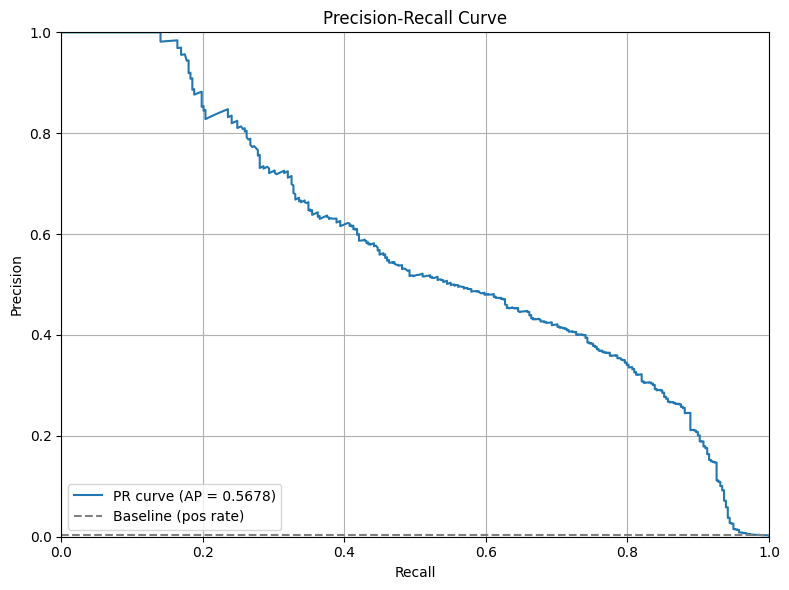

In [136]:
# Precision-Recall curve visualization
probas = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.hlines(y=y_test.mean(), xmin=0, xmax=1, colors='gray', linestyles='--', label='Baseline (pos rate)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: После перебора гиперпараметров PR-AUC стал выше 0.5 и модель начала преобретать минимальную предсказательную способность. PR кривая также улучшилась и при пороге для Recall = 0,8 можно получить Precision около 0.3, тогда как до перебора гиперпараметров, Precision в этой точке был почти равен 0.

Эта модель является чуть лучше чем базовая. От нее можно отталкиваться при дальнейшем улучшении качества путем FE или обучения более сложных моделей.

Далее попробуем перебрать гиперпараметры для верси модели с андерсемплингом через TomekLinks и отдельно с баансировкой классов.

# BASELINE + [OVER/UNDESAMPLING, CLASS BALANCE] + OPTUNA

In [110]:
X = df_total.drop(['TARGET', 'ID'], axis=1)
y = df_total['TARGET']
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [111]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 2500, 10000, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 5.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 5.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 32),
        'auto_class_weights': 'SqrtBalanced',
    }

    model = CatBoostClassifier(
        **params,
        task_type='GPU',
        eval_metric='PRAUC',
        random_seed=42,
    )

    model.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        cat_features=categorical_features,
        use_best_model=True,
        early_stopping_rounds=100,
        verbose=False,
        plot=False,
    )

    preds = model.predict_proba(X_test)[:, 1]
    pr_auc = average_precision_score(y_test, preds)
    trial.set_user_attr('best_iteration', model.get_best_iteration())
    trial.set_user_attr('model', model)
    return pr_auc


study = optuna.create_study(direction='maximize', study_name='catboost_pr_auc')
study.optimize(objective, n_trials=20, timeout=3600, show_progress_bar=True)

print(f'Best PR-AUC: {study.best_value:.5f}')
print('Best parameters:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')

  0%|          | 0/20 [00:00<?, ?it/s]

Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 

Best PR-AUC: 0.56676
Best parameters:
  iterations: 9206
  depth: 9
  learning_rate: 0.1146682953205171
  l2_leaf_reg: 6.21885523757199
  bagging_temperature: 0.5780760774423516
  random_strength: 3.6063724442640206
  border_count: 181
  grow_policy: SymmetricTree
  min_data_in_leaf: 7


In [112]:
best_model = study.best_trial.user_attrs['model']

In [114]:
study.best_trial.user_attrs['model'].save_model('optuna_model_class_balance.cbm')

In [115]:
roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.9710853031173335

In [116]:
f1_score(y_test, best_model.predict(X_test))

0.4978973927670311

In [117]:
average_precision_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.5667626357499412

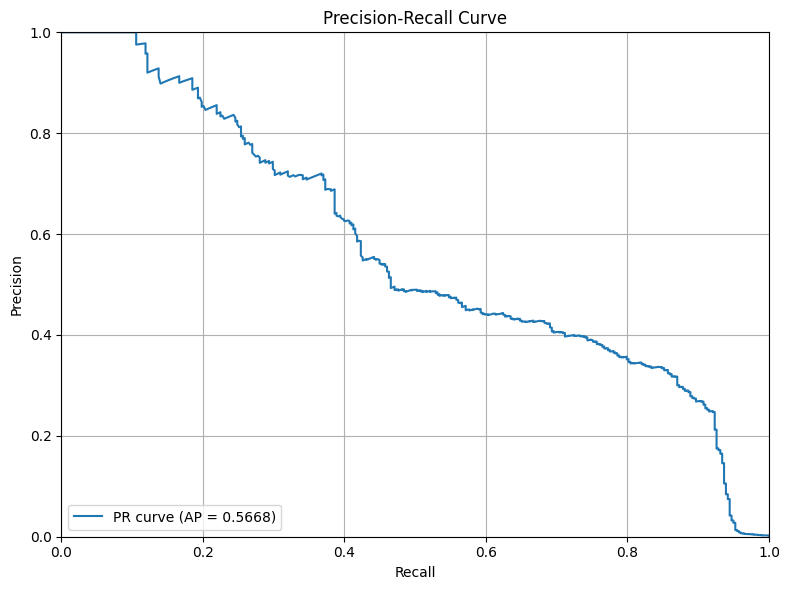

In [119]:
# Precision-Recall curve visualization
probas = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

In [120]:
X = df_total_lr.drop(['TARGET', 'ID'], axis=1)
y = df_total_lr['TARGET']
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [121]:
X_train_us, y_train_us = undersampler.fit_resample(X_train, y_train)

In [122]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)


def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 2500, 10000, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 5.0),
        'random_strength': trial.suggest_float('random_strength', 0.0, 5.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 32),
        'auto_class_weights': trial.suggest_categorical('auto_class_weights', [None, 'Balanced', 'SqrtBalanced']),
    }

    model = CatBoostClassifier(
        **params,
        task_type='GPU',
        eval_metric='PRAUC',
        random_seed=42,
    )

    model.fit(
        X_train_us,
        y_train_us,
        eval_set=(X_val, y_val),
        use_best_model=True,
        early_stopping_rounds=100,
        verbose=False,
        plot=False,
    )

    preds = model.predict_proba(X_test)[:, 1]
    pr_auc = average_precision_score(y_test, preds)
    trial.set_user_attr('best_iteration', model.get_best_iteration())
    trial.set_user_attr('model', model)
    return pr_auc


study = optuna.create_study(direction='maximize', study_name='catboost_pr_auc')
study.optimize(objective, n_trials=20, timeout=3600, show_progress_bar=True)

print(f'Best PR-AUC: {study.best_value:.5f}')
print('Best parameters:')
for key, value in study.best_params.items():
    print(f'  {key}: {value}')

  0%|          | 0/20 [00:00<?, ?it/s]

Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 5 because PRAUC is/are not implemented for GPU
Metric PRAUC is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Default metric period is 

Best PR-AUC: 0.55194
Best parameters:
  iterations: 9968
  depth: 10
  learning_rate: 0.05514413357163747
  l2_leaf_reg: 0.23476305530429903
  bagging_temperature: 3.2880996886164358
  random_strength: 0.14010698398395502
  border_count: 106
  grow_policy: SymmetricTree
  min_data_in_leaf: 23
  auto_class_weights: None


In [123]:
best_model = study.best_trial.user_attrs['model']

In [124]:
study.best_trial.user_attrs['model'].save_model('optuna_model_tomek_links.cbm')

In [125]:
roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.9676824909206567

In [126]:
f1_score(y_test, best_model.predict(X_test))

0.4409171075837742

In [127]:
average_precision_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.5519410230158199

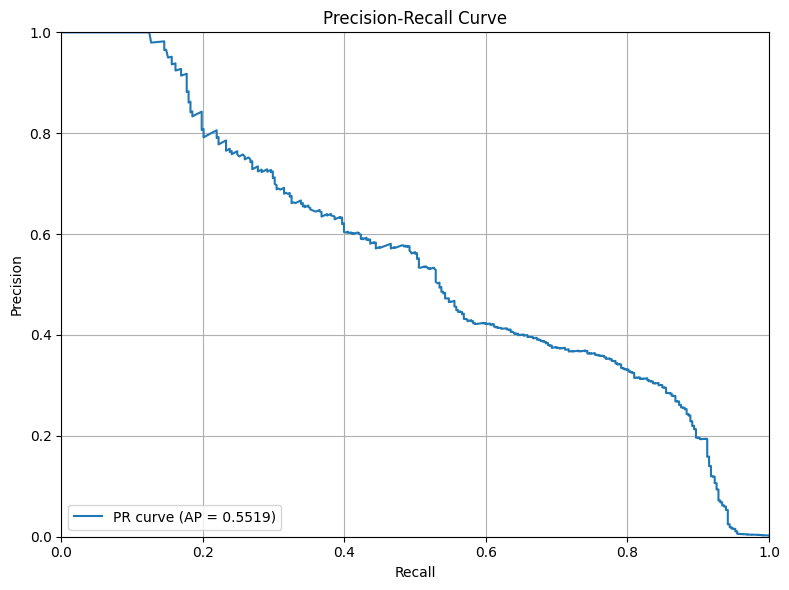

In [128]:
# Precision-Recall curve visualization
probas = best_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, probas)
ap_score = average_precision_score(y_test, probas)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR curve (AP = {ap_score:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show() 

**Вывод**: Версия с балансировкой классов и андерсекмплингом показали результаты хуже, чем базовый вариант без калибровок. PR-AUC базовой модели с перебором гиперпараметров равен 0.56785 тогда как варианты с балансировкой и андерсемплингом показали результаты 0.56676 и 0.55194. Для baseline также осталвяем первый вариант.